In [1]:
#Odwrócić kolejność predykcji w LSTM
#Użyć jako wejścia dla każdego elementu dekodera ukrytego stanu

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler

Matplotlib is building the font cache; this may take a moment.
/pio/scratch/1/i309016/miniconda/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
with open("../Dane/Datasets/d10.pickle", "rb") as file:
    dataset=pickle.load(file)

resampler=TimeSeriesResampler(200)

dataset=torch.Tensor([resampler.transform(ar.reshape((1,-1,1))).reshape(-1,1) for ar in dataset]).transpose(0,1)

In [4]:
class Siec(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer=nn.Transformer(num_encoder_layers=3, num_decoder_layers=3, d_model=1, nhead=1)
        
    def forward(self, X):
        M=self.transformer.generate_square_subsequent_mask(X.shape[0]).to("cuda")
        T=torch.zeros_like(X,device="cuda")
        T[1:,:,:]=X[:-1,:,:]
        X=self.transformer(X,T, M, M)
        return X

In [8]:
def uczModel(model, dataset, validationset, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50):
    def evalBatch(batch):
        if ifCuda:
            batch=batch.to("cuda")
        result=model(batch)
        diffrenceWithNext=(result-batch)**2
        score=torch.sum(diffrenceWithNext)
        return score
    
    if ifCuda:
        model=model.to("cuda")
    
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    
    try:    
        for epoch in range(epoch_count):
            #Training
            for batch_ind in range(0,dataset.shape[1],batch_size):
                batch=dataset[:,batch_ind:batch_ind+batch_size,:]
                iter_counter+=1
                optimizer.zero_grad()
                score=evalBatch(batch)
                score.backward()
                optimizer.step()
                if iter_counter % log_every == 0:
                    print("Minibatch {0: >6}  | avg. loss {1: >9.7f}".format(
                        iter_counter,score.item()/batch_size))
            #Validation
            validationScore=0
            with torch.no_grad():
                for batch_ind in range(0,validationset.shape[1],batch_size):
                    batch=validationset[:,batch_ind:batch_ind+batch_size,:]
                    validationScore+=evalBatch(batch)
            avgValidationScore=validationScore/validationset.shape[1]

            if avgValidationScore < bestAvgValidationScore:
                best_epoch = epoch
                bestAvgValidationScore=avgValidationScore
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid score: {1: >9.7f} | best valid score: {2: >9.7f} | best epoch {3: >3}".format(
                epoch, avgValidationScore, bestAvgValidationScore, best_epoch
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
            with open(f"../Modele/Transformer-d10-kopiaZapasowa.pickle","wb") as plik:
                pickle.dump(model, plik)
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param       

In [9]:
model=Siec()

In [10]:
dataset.shape

torch.Size([200, 32897, 1])

In [ ]:
podzial=30000
W=uczModel(model, dataset[:,:podzial,:],dataset[:,-podzial:,:], batch_size=128, 
           log_every=20, lr=0.001, epoch_count=30)

--------------------------------------------------------------------------------------
After epoch  5 | valid score: 0.0073183 | best valid score: 0.0073183 | best epoch   5
--------------------------------------------------------------------------------------
Minibatch   1420  | avg. loss 0.0044345


In [23]:
szereg=dataset[:,0:2,:]
szereg=szereg.to("cuda")

In [24]:
X=model(szereg)

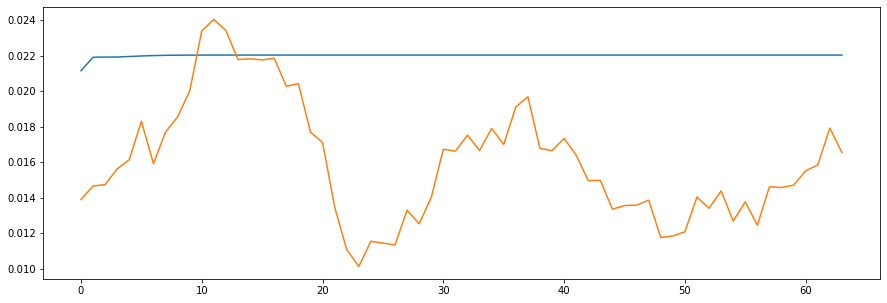

In [25]:
plt.gcf().set_size_inches((15,5))
#plt.xlim((200,300))
plt.plot(np.array(X[:,1,0].cpu().detach()))
plt.plot(np.array(szereg[:,1,0].cpu()))

In [17]:
X.shape

torch.Size([648, 2, 1])

In [20]:
szereg[0].shape

torch.Size([648, 1])

In [21]:
np.sum((np.array(X[:,0,0].cpu().detach())-np.array(szereg[0]).ravel())**2)

0.028372977

In [12]:
np.sum((np.array(X[:-1,1,0].cpu().detach())-np.array(szereg[1][1:]).ravel())**2)

0.47306597

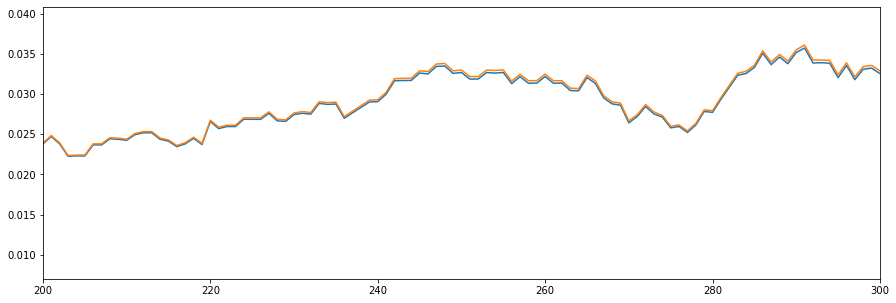

In [42]:
plt.gcf().set_size_inches((15,5))
plt.xlim((200,300))
plt.plot(np.array(X[:,0,0].cpu().detach()))
plt.plot(np.array(szereg[0]))

In [51]:
np.sum((np.array(X[:,0,0].cpu().detach())-np.array(szereg[0]).ravel())**2)

2.3230652e-05

In [52]:
np.sum((np.array(X[:-1,0,0].cpu().detach())-np.array(szereg[0][1:]).ravel())**2)

0.00052029593